## Inertial oscillation and wind direction

### Introduction
This notebook aims to visualize inertial oscillations as well as wind fluctuations.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

## Import Library


In [24]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation

## Read Drifter Data


In [25]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables


In [26]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [27]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data


In [28]:
# Test: Our selected drifter has 840 observations. However, we will limit it to 158 observations because the coordinates 
# of our CMEMS data are 158 in dimension, and the linear interpolation method we use requires it in this situation.

df_1 = df[16129:16290]
df_1

,longitude,latitude,time,ve,vn,sst
16129,-1.824,2.193,2023-01-01 00:00:00,-0.20141,0.03785,29.958
16130,-1.859,2.201,2023-01-01 06:00:00,-0.19177,-0.00909,29.682
16131,-1.898,2.190,2023-01-01 12:00:00,-0.22554,-0.05266,29.991
16132,-1.946,2.180,2023-01-01 18:00:00,-0.18678,-0.05015,29.888
16133,-1.971,2.170,2023-01-02 00:00:00,-0.16427,0.00519,29.645
...,...,...,...,...,...,...
16285,-2.393,1.452,2023-02-09 00:00:00,-0.05208,-0.00764,29.370
16286,-2.407,1.443,2023-02-09 06:00:00,-0.09199,-0.01783,29.316
16287,-2.429,1.445,2023-02-09 12:00:00,-0.10036,-0.00318,29.521
16288,-2.446,1.442,2023-02-09 18:00:00,-0.09536,0.02611,29.550


## Visualisation of Inertial oscillation and wind direction


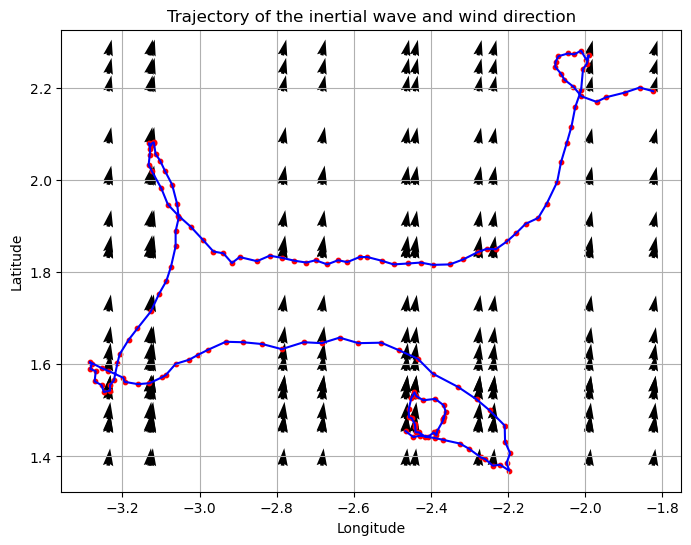

In [46]:

# Load the DataFrame containing information about the inertial wave
df_inertial_wave = df[16129:16290]  # Make sure to provide the correct file path

# Load data from the NetCDF file containing the U and V wind components
ds_wind = xr.open_dataset("cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc")  # Make sure to provide the correct file path

# Select the U and V wind variables
u_wind = ds_wind['eastward_wind']
v_wind = ds_wind['northward_wind']

# Interpolate wind data to the same spatial positions as the inertial wave data
u_interp = u_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')
v_interp = v_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

# Calculate mean longitude and latitude values
mean_longitude = df_inertial_wave['longitude'].mean()
mean_latitude = df_inertial_wave['latitude'].mean()

# Average u_interp and v_interp values along time
mean_u_interp = np.mean(u_interp, axis=0)
mean_v_interp = np.mean(v_interp, axis=0)

# Specify the desired number of points for the inertial wave grid
desired_lon_points = 20
desired_lat_points = 10

# Calculate subsampling factors
lon_subsample_factor = int(df_inertial_wave['longitude'].size / desired_lon_points)
lat_subsample_factor = int(df_inertial_wave['latitude'].size / desired_lat_points)

# Subsample wind data to match the resolution of the inertial wave grid
u_interp_subsampled = u_interp[:, ::lon_subsample_factor, ::lat_subsample_factor]
v_interp_subsampled = v_interp[:, ::lon_subsample_factor, ::lat_subsample_factor]

# Display quivers with mean values
plt.figure(figsize=(8, 6))
plt.quiver(u_interp_subsampled.longitude.values, v_interp_subsampled.latitude.values, u_interp_subsampled.mean(axis=0), v_interp_subsampled.mean(axis=0), scale=(150), width=0.02)
plt.scatter(df_inertial_wave['longitude'], df_inertial_wave['latitude'], color='red', s=10)
 
# Plot the line connecting trajectory points
plt.plot(df_inertial_wave['longitude'], df_inertial_wave['latitude'], color='blue', linestyle='-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory of the inertial wave and wind direction')
# plt.colorbar(label='Inertial wave')
plt.savefig("fig21 mode.png")
plt.grid(True)
plt.show()

## Conclusion

 - We notice that both $v_e$ and $v_n$ begin their oscillations at the South Pole and move towards the North Pole.
 - It should be noted that the direction of these inertial oscillations indeed confirms certain climatic hypotheses related to the generation of such waves.
 - En effet, d'après l'article de Shengli Chen et al sur Oscillations inertielles locales dans l’océan de surface générées par des vents variant dans le temps, ces oscillations sont généralement générer par le vent et suivent leur sens de propagation. D'après nos résultats, ces vents sont connus sous le nom de vents polaires ou vents du sud. (voir : https://www.researchgate.net/publication/283309082_Local_inertial_oscillations_in_the_surface_ocean_generated_by_time-varying_winds)